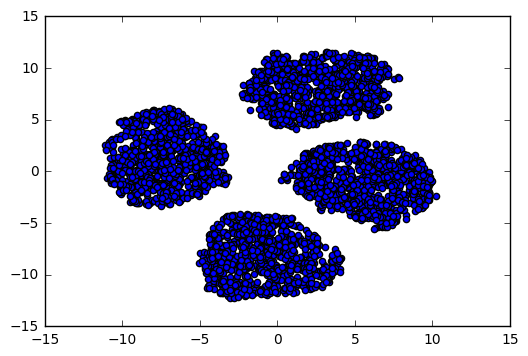

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.manifold import TSNE

dim = 4
params = [(np.random.rand(1,dim) * 100, abs(np.random.random() * 5)) for _ in range(4)]
n = 1000
X = np.ndarray((0,dim))
for mu, sigma in params:
    X = np.append(X, sigma * np.random.randn(n, dim) + mu, axis=0)

# reduce the dimensionality of the data set so we can plot it
model = TSNE(n_components=2, perplexity=80)
reduced = model.fit_transform(X)

plt.scatter(reduced[:,0], reduced[:,1])

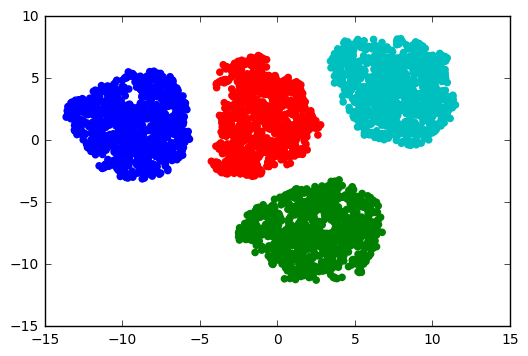

In [27]:
kmeans = cluster.KMeans(len(params))
kmeans.fit(X)
colors = "rgbcyk"
cs = [colors[i % len(colors)] for i in kmeans.labels_]
plt.scatter(reduced[:,0], reduced[:,1], color=cs)

In [3]:
import math
from fractions import Fraction
import numpy as np
import collections
from collections import Counter, defaultdict

data_dict=[
	{'A1':'A','A2':70,'A3':True, 'Class':'Class1'},
    {'A1':'A','A2':90,'A3':True, 'Class':'Class2'},
   	{'A1':'A','A2':85,'A3':False, 'Class':'Class2'},
   	{'A1':'A','A2':95,'A3':False, 'Class':'Class2'},
    {'A1':'A','A2':70,'A3':False, 'Class':'Class1'},
    {'A1':'B','A2':90,'A3':True, 'Class':'Class1'},
    {'A1':'B','A2':78,'A3':False, 'Class':'Class1'},
    {'A1':'B','A2':65,'A3':True, 'Class':'Class1'},
    {'A1':'B','A2':75,'A3':False, 'Class':'Class1'},
    {'A1':'C','A2':80,'A3':True, 'Class':'Class2'},
    {'A1':'C','A2':70,'A3':True, 'Class':'Class2'},
    {'A1':'C','A2':80,'A3':False, 'Class':'Class1'},
    {'A1':'C','A2':80,'A3':False, 'Class':'Class1'},
    {'A1':'C','A2':96,'A3':False, 'Class':'Class1'}   
]


"""
========================================
calcH: calculates the H for the Entropy
----------------------------------------
-probabilities: an array of the 
probabilities of the classifications
========================================
"""
def calcH(probabilities):
	return sum(-p*math.log(p,2) for p in probabilities)
	H = 0.0
	for p in probabilities:
		H=H-p*math.log(p,2)
	return H


"""
=====================================================================
calcGain: calculates gain of each attributes
---------------------------------------------------------------------
-data_dict: data set that you would like to analyze
-attribute: the attribute you would like to get probabilities for
-attr_probabilities: the probabilities for the different values of
given attribute
-probabilities:  an array of the probabilities of the classifications
======================================================================
"""
def calcGain(data_dict,attribute, attr_probabilities, probabilities):
	H=calcH(probabilities)
	HAttribute=0.0
	denominator=len(data_dict)
	numerators=Counter(data[attribute] for data in data_dict)
	for attr, attr_ps in attr_probabilities.items():
		HT = calcH(attr_ps)
		HAttribute = HAttribute + (Fraction(numerators[attr],denominator)*HT)

	print("HAttribute: {0}".format(HAttribute))	

	gain=H-HAttribute
	print("gain: {0}".format(gain))
	return gain

"""
===================================================================
getAttrProbabilities: gets the probabilities for a given attribute
-------------------------------------------------------------------
-data_dict: data set that you would like to analyze
-attribute: the attribute you would like to get probabilities for
-classification: the class that you are using to get resulting tree
===================================================================
"""
def getAttrProbabilities(data_dict, attribute, classification):
	probabilities= defaultdict(list)
    
	attr_denominators=Counter(data[attribute] for data in data_dict)
	class_counts = Counter((data[attribute], data[classification]) for data in data_dict)
	for data_pair, class_count in class_counts.items():
		attr, classification = data_pair
		probabilities[attr].append(Fraction(class_count, attr_denominators[attr]))
	return probabilities


"""
==============================================================
getClassProbabilities: calculates probabilities for H
--------------------------------------------------------------
-data_dict: data dictionary to look at 
-classification: attribute that is used for the classification
===============================================================
"""
def getClassProbabilities(data_dict,classification):
	denominator=len(data_dict)
	classifications=[]
	sorted_dict=sorted(data_dict, key=lambda attribute: attribute[classification])
	current_class=sorted_dict[0][classification]
	class_count=0

	for i in sorted_dict:
		if(i[classification]==current_class):
			class_count+=1
		else:
			classifications.append(class_count)
			class_count=1
			current_class=i[classification]

	classifications.append(class_count)
	probabilities=[Fraction(j,denominator) for j in classifications]
	return probabilities

def partitionNumericalData(data_dict, attr, classification):
    median = sorted(data_dict, key=lambda d: d[attr])[len(data) // 2]
    smaller = [d for d in data_dict if d[attr] < median]
    bigger = [d for d in data_dict if d[attr] >= median]
    return smaller, bigger, median

"""
==============================================================
getSplittingAttribute: gets the splitting attribute of the 
given data set
--------------------------------------------------------------
-data_dict: data dictionary to look at 
-attr_types: data dictionary that has the type of each attribute
in the given data set
===============================================================
"""
def getSplittingAttribute(data_dict,attr_types):
	attr_gains={}
	classification=None

	for attr_class in attr_types:
		if(attr_class[1]=="class"):
			classification=attr_class[0]
	probabilities=getClassProbabilities(data_dict,classification)
	for a_name in attr_types:
		if(a_name[1]=="categorical"):
			print("ATTRIBUTE: {0}".format(a_name[0]))
			print ("===========================")
			attr_probabilities=getAttrProbabilities(data_dict,a_name[0],classification)
			attr_gains[a_name[0]]=calcGain(data_dict,a_name[0],attr_probabilities,probabilities)
			print ("\n")
		elif(attr_types[1]=="numerical"):
			print("ATTRIBUTE: {0}".format(a_name[0]))
			print ("===========================")
			smaller, bigger, median = partitionNumericalData(data_dict, a_name[0], classification)

			HT_smaller = calcH(getClassProbabilities(smaller))
			HT_bigger = calcH(getClassProbabilities(bigger))
			HTAttribute = Fraction(len(smaller),len(data_dict))*HT_smaller + Fraction(len(bigger),len(data_dict))*HT_bigger
			H = calcH(probabilities)
			attr_gains[a_name[0]] = H - HTAttribute
			print ("\n")
	spiltAttr=list(attr_gains.keys())[0]
	for attr in attr_gains:
		if(attr_gains[attr]>attr_gains[spiltAttr]):
			spiltAttr=attr
	print("Splitting Attribute = {0}".format(spiltAttr))
	return spiltAttr

"""
==============================================================
getAttrTypes: gets the attrutes and their types 
--------------------------------------------------------------
-filePath: the path of the file with the attributes and their 
types
===============================================================
"""
def getAttrTypes(filePath):
	attr_types=[]
	with open(filePath, 'r') as fileHandler:
		for line in fileHandler:
			line = line.strip()
			attr=line.split(":")
			attr_types.append(attr)
	return attr_types

"""
==============================================================
getDataDict: reads in a data set and turns it into a data 
dictionary
--------------------------------------------------------------
-attr_types: the attributes along with what types they are
-filePath: the path of the file with the data set
===============================================================
"""
def getDataDict(attr_types,filePath):
	data_dict=[]
	fileHandler=open(filePath,"r")
	line=fileHandler.readline().strip()
	
	while(line!=""):
		if("?" not in line):
			data_set_row=line.split(",")
			data_dict_row={}
			index=0
			for a_name in attr_types:
				data_dict_row[a_name[0]]=data_set_row[index]
				index+=1
			
			index=0
			data_dict.append(data_dict_row)
		line=fileHandler.readline().strip()

	return data_dict

def createDecsionTree(data_dict,attr_types,tree):
	if(len(attr_types)>1):
		getSplittingAttribute(data_dict,attr_types)
	else:
		return tree


"""
==============================
			MAIN 
==============================
"""
def main():
	attr_types=getAttrTypes("./attributes.txt")
	#print(attr_types)
	data_dict=getDataDict(attr_types,"./dataset.txt")
	#attr_types=[["A1","categorical"],["A2","continuous"],["A3","categorical"],["Class","class"]]
	getSplittingAttribute(data_dict,attr_types)

if __name__ == '__main__':
    main()

ATTRIBUTE: workclass
HAttribute: 0.7146083455586414
gain: 0.07898288445306512


ATTRIBUTE: education
HAttribute: 0.5564352761388716
gain: 0.23715595387283495


ATTRIBUTE: marital-status
HAttribute: 0.7254216346112524
gain: 0.06816959540045409


ATTRIBUTE: occupation
HAttribute: 0.5799643121067035
gain: 0.213626917905003


ATTRIBUTE: relationship
HAttribute: 0.69925080436224
gain: 0.09434042564946654


ATTRIBUTE: race
HAttribute: 0.7577076738012829
gain: 0.035883556210423606


ATTRIBUTE: sex
HAttribute: 0.7934269874859291
gain: 0.00016424252577740273


ATTRIBUTE: native-country
HAttribute: 0.7099381602670793
gain: 0.08365306974462716


Splitting Attribute = education
